Загрузка необходимых библиотек

In [3]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
from neo4j import GraphDatabase

In [4]:
from py2neo import Graph, Node, Relationship, NodeMatcher, walk
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

In [5]:
import logging
from neo4j.exceptions import ServiceUnavailable

Загрузка данных и создание датафрейма

In [6]:
url='https://drive.google.com/file/d/1svO6qyERYRzDimI_WRbwPDPOIWhCrfRT/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
response = requests.get(dwn_url)
content = response.content.decode('utf-8')
csv_raw = StringIO(content)
df = pd.read_csv(csv_raw, sep=';')
print(df.head())

   id события         ФИО участника события 1          ФИО участника события 2
0         189  Галчевская Карина Владимировна  Белоновская Анастасия Семеновна
1         206         Офицеров Олег Романович        Сапожник Борис Валерьевич
2         445     Жандарова Лариса Германовна       Чемодуров Дамир Русланович
3         503          Масимова Яна Дамировна   Мингажетдинов Рамиль Семенович
4         571       Мухтарова Алена Яковлевна      Щербатенко Ольга Робертовна


Изменим названия колонок для более удобного обращения к ним.
Конвертируем датафрейм в словарь для загрузки в neo4j.

In [7]:
df = df.rename(columns={'id события': 'id', 'ФИО участника события 1': 'name1', 'ФИО участника события 2': 'name2'})
data = df.to_dict('records')

Подключение к neo4j:

In [8]:
uri = "neo4j+s://0e2eaff8.databases.neo4j.io"
user = "neo4j"
password = "bHhlshCQoJYigbWabFu26fwmLHtDG2GRDIbEyP60GJM"
graph = Graph(uri, auth=(user, password))
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

Загрузка датафрейма в neo4j:

In [9]:
data_ = data.copy()

In [10]:
with driver.session() as session:
    query = """
        UNWIND $data_ AS row
        MERGE (n1:Person {name: row.name1})
        MERGE (n2:Person {name: row.name2})
        MERGE (n1)-[r:RELATIONSHIP {id: row.id}]-(n2)
            """
    session.run(query, data_=data_)

Датафрейм загружен, далее реализуем несколько запросов к нему:

Запрос №1 выведет первые 20 узлов имеющих наиболшее количество связей

In [11]:
query = """
    MATCH (n)
    RETURN n, size([(n)--() | 1]) AS connections
    ORDER BY connections DESC
    LIMIT 15
        """
graph.run(query).data()

[{'n': Node('Person', name='Ахромеева Алина Ивановна'), 'connections': 50},
 {'n': Node('Person', name='Башнина Антонина Глебовна'), 'connections': 14},
 {'n': Node('Person', name='Медведева Дарья Алексеевна'), 'connections': 6},
 {'n': Node('Person', name='Зимнухова Карина Даниловна'), 'connections': 5},
 {'n': Node('Person', name='Диомидов Игорь Ильдарович'), 'connections': 5},
 {'n': Node('Person', name='Шолохов Игорь Робертович'), 'connections': 4},
 {'n': Node('Person', name='Двигубская Валентина Геннадьевна'),
  'connections': 3},
 {'n': Node('Person', name='Пафомова Кира Вадимовна'), 'connections': 3},
 {'n': Node('Person', name='Ивашев Вячеслав Игоревич'), 'connections': 2},
 {'n': Node('Person', name='Даниленко Владимир Семенович'), 'connections': 2},
 {'n': Node('Person', name='Анихнова Тамара Руслановна'), 'connections': 2},
 {'n': Node('Person', name='Майлина Гульнара Ивановна'), 'connections': 2},
 {'n': Node('Person', name='Нагайцева Анжелика Яновна'), 'connections': 2},


In [12]:
query = """
    MATCH (n:Person)
    WHERE size([(n)--(m) | 1]) <= 1
    RETURN n
        """
len(graph.run(query).data())

9872

Абсолютное большинство узлов-фио имеет лишь одну связь.
Однако первично просмотрев датафрейм, мы не увидели того, что некоторые имена встречаются более одного раза.
Проверим это в Pandas.

In [13]:
df.name1.count() == df.name1.nunique()

False

In [14]:
df.name2.count() == df.name2.nunique()

False

In [15]:
df.name1.value_counts().head(10)

Ахромеева Алина Ивановна           49
Башнина Антонина Глебовна          14
Диомидов Игорь Ильдарович           5
Зимнухова Карина Даниловна          4
Пафомова Кира Вадимовна             2
Шолохов Игорь Робертович            2
Думин Максим Русланович             1
Барахнин Дамир Робертович           1
Минулин Валентин Юрьевич            1
Хорошихина Оксана Станиславовна     1
Name: name1, dtype: int64

In [16]:
df.name2.value_counts().head(10)

Медведева Дарья Алексеевна          5
Двигубская Валентина Геннадьевна    2
Шолохов Игорь Робертович            2
Белоновская Анастасия Семеновна     1
Шлякова Маргарита Алексеевна        1
Юрлов Геннадий Рамилевич            1
Смиренский Ян Рамилевич             1
Чарыев Ефим Валентинович            1
Карюк Римма Робертовна              1
Сергеенков Альберт Эдуардович       1
Name: name2, dtype: int64

Так и есть, небольшое количество имён встречается более одного раза.

Визуализируем несколько узлов

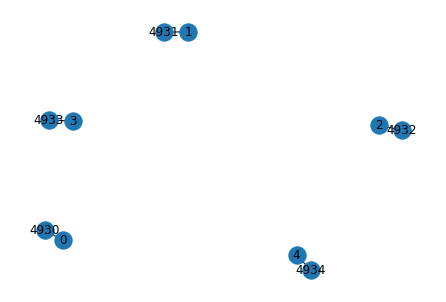

In [18]:
G = nx.Graph()
result = graph.run("""
    MATCH (n)-[r]-(p)
    RETURN n,r,p       
    LIMIT 10
                   """).data()
for record in result:
     n = record["n"]
     r = record["r"]
     p = record["p"]     
     G.add_edge(n.identity, p.identity)
nx.draw(G, with_labels=True)
plt.show()

Визуально мы можем увидеть, что большинство графов выглядят как два связанных между собой узла

In [19]:
# Все уникальные узлы (количество)
query = """
    MATCH (n)
    RETURN count(n)
        """
graph.run(query).data()

[{'count(n)': 9899}]

In [20]:
# Уникальные узлы с количеством связей более 2-х (количество)
query = """
    MATCH (n)
    WHERE size([(n)--() | 1]) > 2
    RETURN count(n)
        """
graph.run(query).data()

[{'count(n)': 8}]

In [21]:
# Уникальные события с количеством связей равным 2-м (количество)
query = """
    MATCH (n)
    WHERE size([(n)--() | 1]) = 2
    RETURN count(n)
        """
graph.run(query).data()

[{'count(n)': 19}]

In [22]:
# Уникальные узлы с количеством связей равным 1-му (количество)
query = """
    MATCH (n)
    WHERE size([(n)--() | 1]) = 1
    RETURN n
        """
len(graph.run(query).data())

9872

Изучим персон, имеющих большое количество связей

Посмотрим на первые и последние 10 узлов по количеству связей

In [23]:
query = """
    MATCH (n:Person)
    RETURN n, size([(n)--() | 1]) AS connections
    ORDER BY connections DESC
    LIMIT 10
        """
restop10d = graph.run(query).data()
restop10d

[{'n': Node('Person', name='Ахромеева Алина Ивановна'), 'connections': 50},
 {'n': Node('Person', name='Башнина Антонина Глебовна'), 'connections': 14},
 {'n': Node('Person', name='Медведева Дарья Алексеевна'), 'connections': 6},
 {'n': Node('Person', name='Диомидов Игорь Ильдарович'), 'connections': 5},
 {'n': Node('Person', name='Зимнухова Карина Даниловна'), 'connections': 5},
 {'n': Node('Person', name='Шолохов Игорь Робертович'), 'connections': 4},
 {'n': Node('Person', name='Пафомова Кира Вадимовна'), 'connections': 3},
 {'n': Node('Person', name='Двигубская Валентина Геннадьевна'),
  'connections': 3},
 {'n': Node('Person', name='Даниленко Владимир Семенович'), 'connections': 2},
 {'n': Node('Person', name='Майлина Гульнара Ивановна'), 'connections': 2}]

In [24]:
query = """
    MATCH (n:Person)
    RETURN n, size([(n)--() | 1]) AS connections
    ORDER BY connections 
    LIMIT 10
        """
graph.run(query).data()

[{'n': Node('Person', name='Офицеров Олег Романович'), 'connections': 1},
 {'n': Node('Person', name='Жандарова Лариса Германовна'), 'connections': 1},
 {'n': Node('Person', name='Масимова Яна Дамировна'), 'connections': 1},
 {'n': Node('Person', name='Мухтарова Алена Яковлевна'), 'connections': 1},
 {'n': Node('Person', name='Русских Кира Константиновна'), 'connections': 1},
 {'n': Node('Person', name='Федонкина Кристина Маратовна'), 'connections': 1},
 {'n': Node('Person', name='Чернолусская Екатерина Марселевна'),
  'connections': 1},
 {'n': Node('Person', name='Оранский Владимир Артурович'), 'connections': 1},
 {'n': Node('Person', name='Ардатов Андрей Анатольевич'), 'connections': 1},
 {'n': Node('Person', name='Галчевская Карина Владимировна'),
  'connections': 1}]

Визуально представим узлы, отличающиеся большим количеством связей

In [25]:
G = nx.Graph()

result = graph.run("""
    MATCH (n:Person)-[r]-(p)
    WHERE size([(n)--() | 1]) > 4
    RETURN n,r,p
                   """).data()

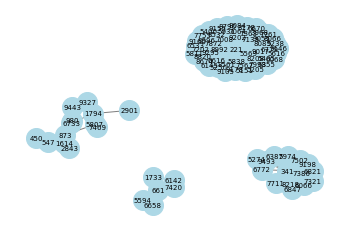

In [26]:
for record in result:
     n = record["n"]
     r = record["r"]
     p = record["p"]
     
     G.add_edge(n.identity, p.identity)

pos = nx.spring_layout(G, k=0.2, iterations=50)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=400)
nx.draw_networkx_edges(G, pos, edge_color='grey') 
nx.draw_networkx_labels(G, pos, font_size=7, font_family='sans-serif')

plt.axis('off')
plt.show()

Можем заметить, что эти визуализация связей этих людей сильно отличаются от того, что мы видели ранее.

Поподробнее изучим человека с 50-ю связями.

In [32]:
query = """
    MATCH (n:Person {name: 'Ахромеева Алина Ивановна'})--(p)
    RETURN p
        """
results50 = graph.run(query)
con1n = graph.run(query).data()
len(graph.run(query).data())

50

Этот человек имеет связи с 50-ю людьми. Этот граф можно назвать сложным сообществом.

Посмотрим на него визуально:

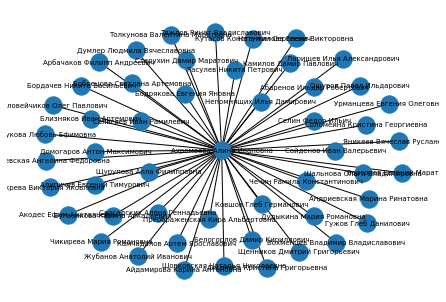

In [33]:
G = nx.Graph()

result50 = graph.run("""
    MATCH (n:Person {name: 'Ахромеева Алина Ивановна'})--(p)
    RETURN n, p
""").data()

for record in result50:
    n = record['n']
    p = record['p']
    G.add_node(n['name'])
    G.add_node(p['name'])
    G.add_edge(n['name'], p['name'])

nx.draw(G, with_labels=True, font_size=7)
plt.show()

In [34]:
query = """
    MATCH (n:Person {name: 'Башнина Антонина Глебовна'})--(p)
    RETURN p
        """
con2n = graph.run(query).data()
len(graph.run(query).data())

14

Башнина А.Г. имеет связи с 14-ю узлами-людьми.

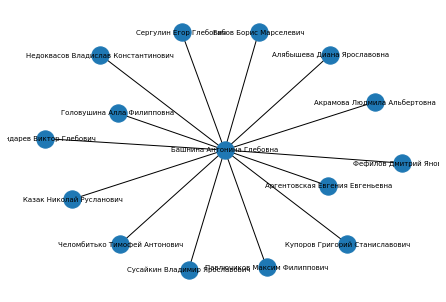

In [35]:
G = nx.Graph()

result50 = graph.run("""
    MATCH (n:Person {name: 'Башнина Антонина Глебовна'})--(p)
    RETURN n, p
""").data()

for record in result50:
    n = record['n']
    p = record['p']
    G.add_node(n['name'])
    G.add_node(p['name'])
    G.add_edge(n['name'], p['name'])

nx.draw(G, with_labels=True, font_size=7)
plt.show()

Повторим это для остальных людей из топа

In [36]:
query = """
    MATCH (n:Person {name: 'Медведева Дарья Алексеевна'})--(p)
    RETURN p
        """
con3n = graph.run(query).data()
len(graph.run(query).data())

6

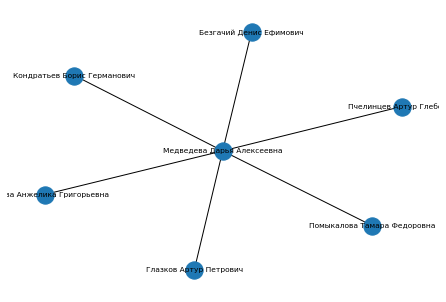

In [37]:
G = nx.Graph()

result50 = graph.run("""
    MATCH (n:Person {name: 'Медведева Дарья Алексеевна'})--(p)
    RETURN n, p
""").data()

for record in result50:
    n = record['n']
    p = record['p']
    G.add_node(n['name'])
    G.add_node(p['name'])
    G.add_edge(n['name'], p['name'])

nx.draw(G, with_labels=True, font_size=7.5)
plt.show()

In [39]:
query = """
    MATCH (n:Person {name: 'Зимнухова Карина Даниловна'})--(p)
    RETURN p
        """
con4n = graph.run(query).data()
len(graph.run(query).data())

5

In [40]:
query = """
    MATCH (n:Person {name: 'Диомидов Игорь Ильдарович'})--(p)
    RETURN p
        """
con5n = graph.run(query).data()
len(graph.run(query).data())

5

Узнаем, есть ли связи в этих сообществах одинаковые узлы

In [41]:
lists = [con1n, con2n, con3n, con4n, con5n]

list_tuples = [list(map(tuple, map(dict.items, lst))) for lst in lists]

intersections = []
for i in range(len(lists)):
    for j in range(i+1, len(lists)):
        intersection = set(list_tuples[i]).intersection(set(list_tuples[j]))
        intersection_dict = dict(intersection)
        intersections.append(intersection_dict)
        print(f'Узел #{i+1} и узел #{j+1} имеют следующие общие связанные узлы: {intersection_dict}')

Узел #1 и узел #2 имеют следующие общие связанные узлы: {}
Узел #1 и узел #3 имеют следующие общие связанные узлы: {}
Узел #1 и узел #4 имеют следующие общие связанные узлы: {}
Узел #1 и узел #5 имеют следующие общие связанные узлы: {}
Узел #2 и узел #3 имеют следующие общие связанные узлы: {}
Узел #2 и узел #4 имеют следующие общие связанные узлы: {}
Узел #2 и узел #5 имеют следующие общие связанные узлы: {}
Узел #3 и узел #4 имеют следующие общие связанные узлы: {}
Узел #3 и узел #5 имеют следующие общие связанные узлы: {}
Узел #4 и узел #5 имеют следующие общие связанные узлы: {}


Общие узлы отсутствуют у всех пар.

Следовательно эти сообщества являются отдельными, независимыми и несвязанными.

Произведём быструю проверку остальных узлов, имеюших более одной связи

In [42]:
# Количесто узлов, связанных с узлами, имеющими более трёх связей
query = """
    MATCH (n:Person)--(p)
    WHERE size([(n)--() | 1]) > 3
    RETURN p 
        """
res3 = graph.run(query).data()
len(res3)

84

In [43]:
# Тот же самый показатель, но без дубликатов
query = """
    MATCH (n:Person)--(p)
    WHERE size([(n)--() | 1]) > 3
    RETURN DISTINCT p 
        """
res3d = graph.run(query).data()
len(res3d)

84

Следовательно здесь пересечений нет

In [44]:
# Количесто узлов, связанных с узлами, имеющими три связей
query = """
    MATCH (n:Person)--(p)
    WHERE size([(n)--() | 1]) = 3
    RETURN p 
        """
res3e = graph.run(query).data()
len(res3e)

6

In [45]:
# Тот же самый показатель, но без дубликатов
query = """
    MATCH (n:Person)--(p)
    WHERE size([(n)--() | 1]) = 3
    RETURN DISTINCT p 
        """
res3ed = graph.run(query).data()
len(res3ed)

5

Итак, кол-во уникальных записей не тождественно всем записям, значит есть некоторое пересечение

In [46]:
# Количесто узлов, связанных с узлами, имеющими три связей
query = """
    MATCH (n:Person)--(p)
    WHERE size([(n)--() | 1]) = 2
    RETURN p 
        """
res2e = graph.run(query).data()
len(res2e)

38

In [47]:
# Тот же самый показатель, но без дубликатов
query = """
    MATCH (n:Person)--(p)
    WHERE size([(n)--() | 1]) = 2
    RETURN DISTINCT p 
        """
res2ed = graph.run(query).data()
len(res2ed)

24

Узнаем, какие узлы связаны с другими узлами дважды

In [48]:
query = """
    MATCH (n1)-[:RELATIONSHIP]-(p1)-[:RELATIONSHIP]-(n2)-[:RELATIONSHIP]-(p2)-[:RELATIONSHIP]-(n1)
    WHERE id(n1) < id(n2)
    RETURN n1, n2, collect(p1) AS commonNodes
        """
graph.run(query).data()

[{'n1': Node('Person', name='Шолохов Игорь Робертович'),
  'n2': Node('Person', name='Ляуданский Валентин Владиславович'),
  'commonNodes': [Node('Person', name='Торгунаков Роман Кириллович'),
   Node('Person', name='Пафомова Кира Вадимовна')]},
 {'n1': Node('Person', name='Пафомова Кира Вадимовна'),
  'n2': Node('Person', name='Торгунаков Роман Кириллович'),
  'commonNodes': [Node('Person', name='Ляуданский Валентин Владиславович'),
   Node('Person', name='Шолохов Игорь Робертович')]}]

Вычислим некоторые меры центральности

In [49]:
import networkx as nx

In [50]:
df

,id,name1,name2
0,189,Галчевская Карина Владимировна,Белоновская Анастасия Семеновна
1,206,Офицеров Олег Романович,Сапожник Борис Валерьевич
2,445,Жандарова Лариса Германовна,Чемодуров Дамир Русланович
3,503,Масимова Яна Дамировна,Мингажетдинов Рамиль Семенович
4,571,Мухтарова Алена Яковлевна,Щербатенко Ольга Робертовна
...,...,...,...
4995,999333,Осташов Владимир Данилович,Чалов Илья Владимирович
4996,999360,Гандыбина Любовь Александровна,Мерлин Илья Юрьевич
4997,999403,Востоков Виктор Ильдарович,Аликас Никита Андреевич
4998,999405,Огарева Людмила Ильдаровна,Нагайцева Алина Степановна


Рассчитаем одну из мер центральности: центральность по степени.

In [51]:
G = nx.Graph()
for index, row in df.iterrows():
    G.add_edge(row['name1'], row['name2'], event=row['id'])
degree_centrality = nx.degree_centrality(G)

Исходя из этой метрики узнаем, у кого самое высокое значение

In [52]:
list(degree_centrality.keys())[list(degree_centrality.values()).index(max(degree_centrality.values()))]

'Ахромеева Алина Ивановна'

Изучим, наименьшие и наибольшие значения метрики

In [53]:
sorted(degree_centrality.values(), reverse=True)[:15]

[0.005051525560719337,
 0.0014144271570014143,
 0.0006061830672863204,
 0.0005051525560719338,
 0.0005051525560719338,
 0.00040412204485754696,
 0.0003030915336431602,
 0.0003030915336431602,
 0.00020206102242877348,
 0.00020206102242877348,
 0.00020206102242877348,
 0.00020206102242877348,
 0.00020206102242877348,
 0.00020206102242877348,
 0.00020206102242877348]

In [54]:
sorted(degree_centrality.values(), reverse=True)[-15:]

[0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674,
 0.00010103051121438674]

Взглянув на наибольшие и наименьшие значения меры центральности по степени, мы можем предположить, что почти все значения одинаковы и лишь меньшинство отличается.

Проверим.

In [55]:
import collections

In [56]:
collections.Counter(degree_centrality.values())

Counter({0.00010103051121438674: 9872,
         0.005051525560719337: 1,
         0.0014144271570014143: 1,
         0.0006061830672863204: 1,
         0.0003030915336431602: 2,
         0.00020206102242877348: 19,
         0.0005051525560719338: 2,
         0.00040412204485754696: 1})

Наше предположение подтвердилось.

Рассчитаем центральность по собственному вектору, эта мера учитывает большее количество данных, поэтому, вероятно, мы получим более полезный результат.

In [57]:
for index, row in df.iterrows():
    G.add_edge(row['name1'], row['name2'], event=row['id'])
eigenvector_centrality = nx.eigenvector_centrality(G)

In [58]:
list(eigenvector_centrality.keys())[list(eigenvector_centrality.values()).index(max(eigenvector_centrality.values()))]

'Ахромеева Алина Ивановна'

В случае с этой метрикой, самое высокое значение также имеет Ахромеева А.И.

Следовательно, этот узел является самым важным и влиятельным в данной бд.

In [59]:
sorted(eigenvector_centrality.values(), reverse=True)[:15]

[0.7075373463769591,
 0.09993907178685205,
 0.09993907178685205,
 0.09993907178685205,
 0.09993907178685205,
 0.09993907178685205,
 0.09993907178685205,
 0.09993907178685205,
 0.09993907178685205,
 0.09993907178685205,
 0.09993907178685205,
 0.09993907178685205,
 0.09993907178685205,
 0.09993907178685205,
 0.09993907178685205]

In [60]:
sorted(eigenvector_centrality.values(), reverse=True)[-15:]

[1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16,
 1.2475527207619724e-16]

Ситуация с этой мерой похожа на ту, что мы видели на предыдущем этапе.

In [61]:
collections.Counter(eigenvector_centrality.values())

Counter({1.2475527207619724e-16: 9794,
         0.7075373463769591: 1,
         0.09993907178685205: 50,
         6.973707596199351e-07: 1,
         1.8637993229981112e-07: 14,
         7.274944765066784e-11: 6,
         1.781990258712493e-10: 1,
         3.013934270411315e-10: 1,
         2.0833427498170872e-10: 1,
         8.311014201971948e-11: 2,
         3.52416460225304e-11: 8,
         3.1502163707650984e-12: 6,
         3.87743370338239e-10: 1,
         2.492803636003745e-10: 1,
         5.5485947023920616e-11: 1,
         7.075665040031119e-11: 2,
         5.503155999136639e-11: 2,
         1.2515772974232443e-10: 2,
         2.101451184031284e-10: 1,
         1.5078600731945607e-10: 1,
         4.6670576329453154e-11: 1,
         1.7638785570319173e-10: 1,
         2.326017588478472e-10: 1})

Здесь распределение величин слегка отличается, однако абсолютное большинство узлов имеют одно и то же значение.

Rest API

К сожалению ранее я никогда не работал с rest-сервисами. Запустить его ниже не получилось

In [62]:
from flask import Flask, request, Response
from networkx.readwrite import graphml

app = Flask(__name__)

@app.route("/graphml")
def get_graphml():
    name = request.args.get("name")

    # Get the person node with the given name
    person_node = graph.nodes.match("Person", name=name).first()

    # Get all the nodes connected to the person_node by the event relationship
    query = """
    MATCH (p:Person {name:$name})-[:event]->(e:Event)<-[:event]-(o:Person)
    RETURN o, e.id
    """
    result = graph.run(query, name=name).data()

    # Create a NetworkX graph object and add the person node and the connected nodes
    G = nx.Graph()
    G.add_node(person_node["name"])
    for record in result:
        node_name = record["o"]["name"]
        edge_id = record["e.id"]
        G.add_edge(person_node["name"], node_name, event_id=edge_id)

    # Convert the NetworkX graph to GraphML format
    graphml_data = graphml.generate_graphml(G)

    # Return the GraphML data as a response
    response = Response(graphml_data, mimetype='text/xml')
    response.headers.set('Content-Disposition', 'attachment', filename='graph.graphml')
    return response

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with watchdog (windowsapi)


SystemExit: 1

D:\Programs\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#SECOND TRY

In [ ]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
uri = "neo4j+s://0e2eaff8.databases.neo4j.io"
username = "neo4j"


def get_graphml_by_name(name):
    with driver.session() as session:
        result = session.run(f"MATCH (n)-[r]-(m) WHERE n.name = '{name}' RETURN n, r, m")
        nodes = []
        edges = []
        for record in result:
            node = record['n']
            nodes.append(node)
            rel = record['r']
            edges.append(rel)
        graphml = build_graphml(nodes, edges)
        return graphml

def build_graphml(nodes, edges):
    graphml = '<?xml version="1.0" encoding="UTF-8"?>\n'
    graphml += '<graphml xmlns="http://graphml.graphdrawing.org/xmlns">\n'
    graphml += '<graph id="G" edgedefault="directed">\n'
    for node in nodes:
        graphml += f'<node id="{node.id}">\n'
        graphml += f'<data key="name">{node["name"]}</data>\n'
        graphml += f'<data key="age">{node["age"]}</data>\n'
        graphml += '</node>\n'
    for edge in edges:
        graphml += f'<edge source="{edge.start_node.id}" target="{edge.end_node.id}"/>\n'
    graphml += '</graph>\n'
    graphml += '</graphml>\n'
    return graphml
